In [1]:
import torch.nn as nn
import torch
from torchvision import models
from datasets.linemod.dataset import DepthDataset
import torch
import os
import torch.nn.functional as F
from lib.loss_depth import L2Loss, GradientLoss, NormalLoss, BerHu
from torch import optim
import numpy as np
import time
import matplotlib.pyplot as plt
from lib.utils import setup_logger, im_convert, depth_to_img
from lib.network import DepthV3, DepthNetPSP, DepthV2
from lib.utils import visualize
import lib.evaluate as evaluate


%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore") 

In [3]:
dataset_root = "./datasets/linemod/Linemod_preprocessed"
log_dir = 'experiments/logs/depth_prediction'
outf = 'trained_models/depth_prediction'

In [18]:
eval_dataset = DepthDataset('eval', dataset_root)
dataloader = torch.utils.data.DataLoader(eval_dataset, 
                                             batch_size=1, 
                                             shuffle=True, 
                                             num_workers=1)

Object 2 buffer loaded
Object 4 buffer loaded
Object 5 buffer loaded
Object 10 buffer loaded
Object 11 buffer loaded


In [32]:
def select_model(version):
    if version == 3:
        model = 'trained_models/depth_prediction/depthv3_71.07109753379609.pth'
        estimator = estimator = DepthV3((480, 640))
        estimator.load_state_dict(torch.load(model))
    elif version == 2:
        model = 'trained_models/depth_prediction/depthv2_0.0002779090425557933.pth'
        estimator = estimator = DepthV2((480, 640))
        estimator.load_state_dict(torch.load(model))
    else:
        model = 'trained_models/depth_prediction/depthv1_0.0005158761957811202.pth'
        estimator = estimator = DepthNetPSP()
        estimator.load_state_dict(torch.load(model))
    return estimator

def plot_depth(version, img, depth):
    estimator = select_model(version=version)    
    estimator.cuda()
    estimator.eval()

    pred_depth = estimator(img).cpu().detach().view(480, 640)
    depth = depth.cpu().view(480, 640)

    visualize(img, depth, pred_depth)
    
def eval_models(version, dataloader):
    estimator = select_model(version=version)    
    estimator.cuda()
    estimator.eval()
    return_log=False
    if version==1 or version == 2:
        return_log = True
    evaluate.run_eval(estimator, dataloader, return_log=return_log)
    

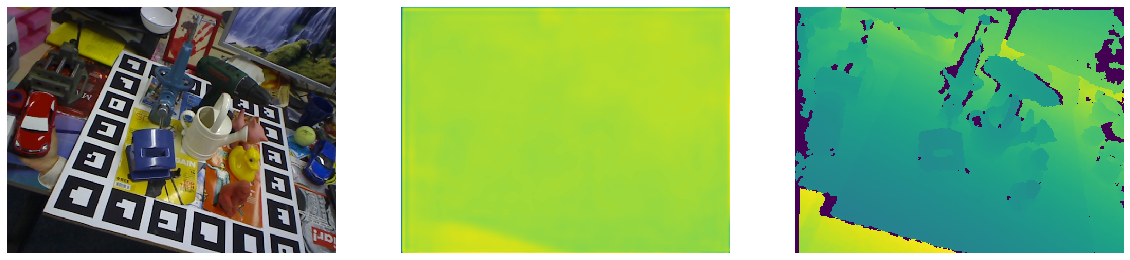

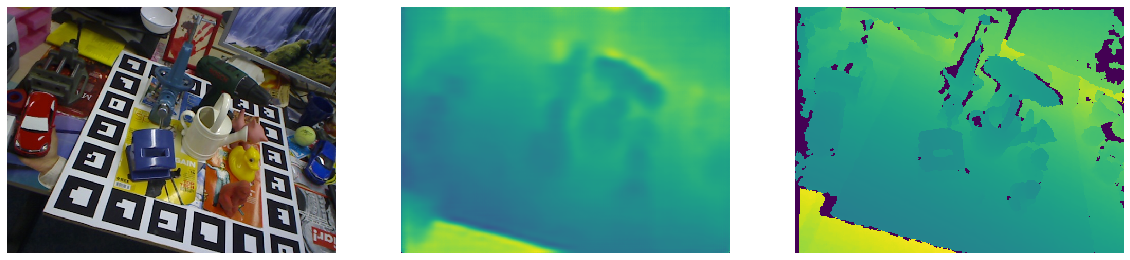

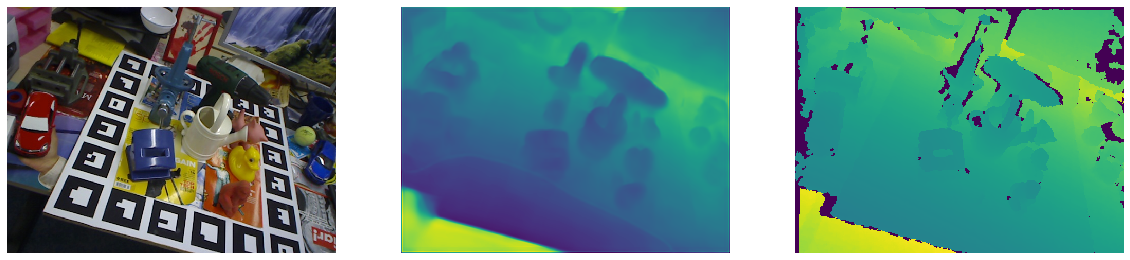

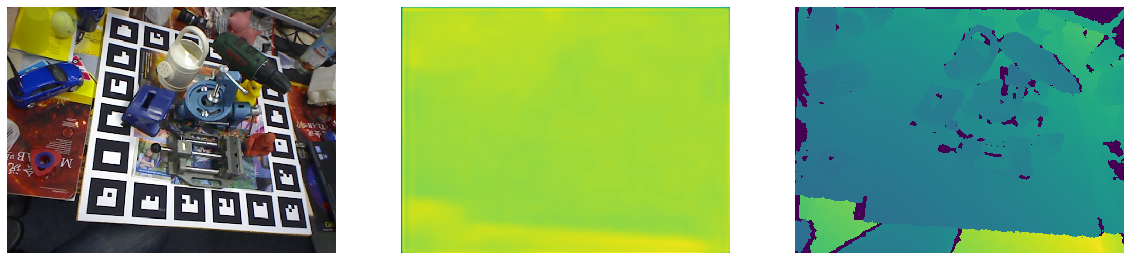

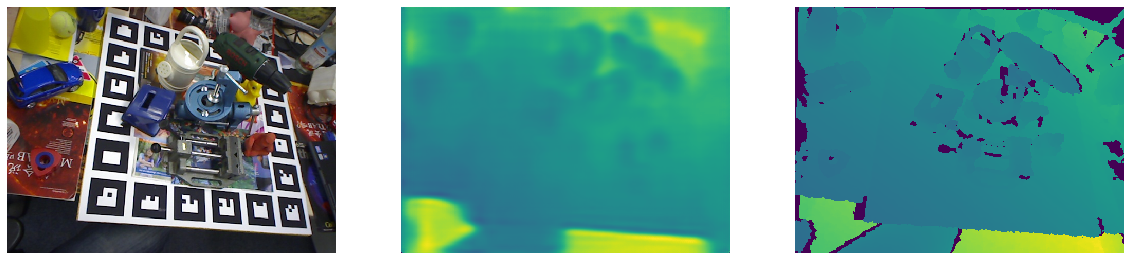

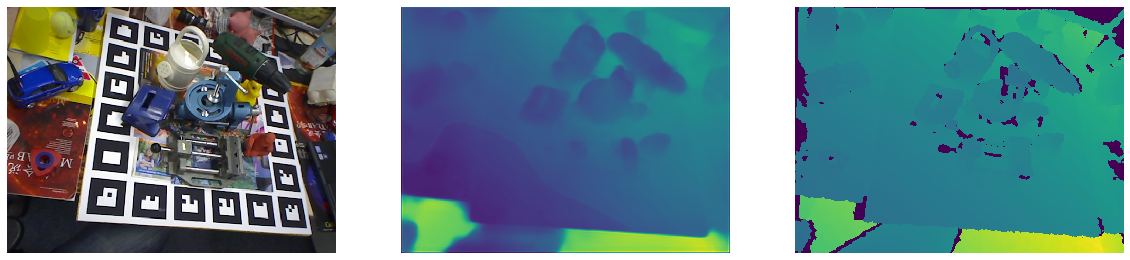

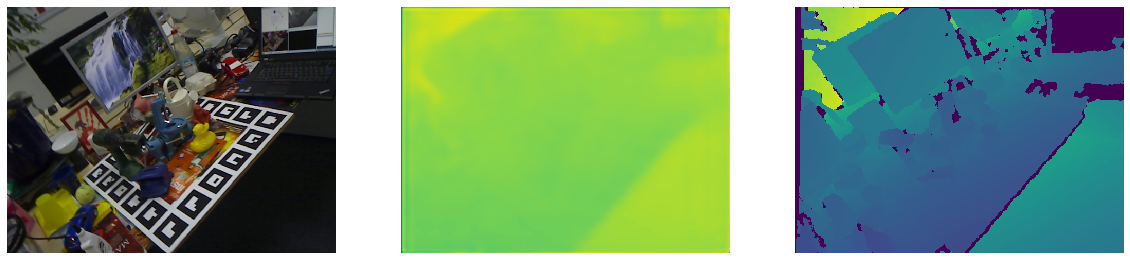

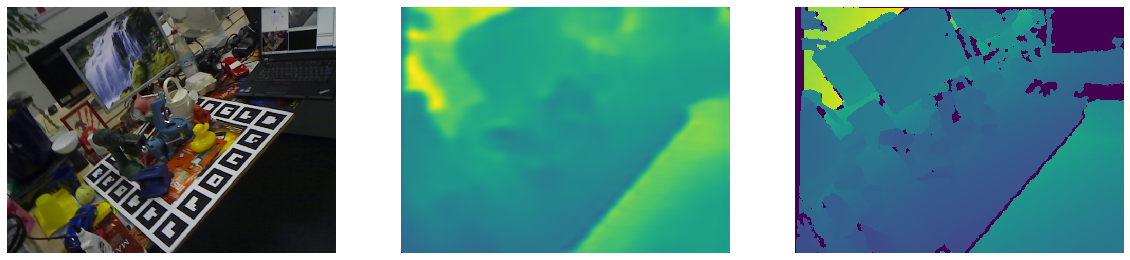

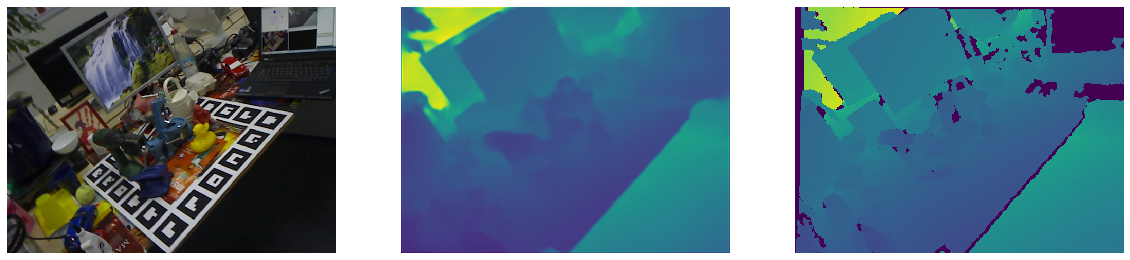

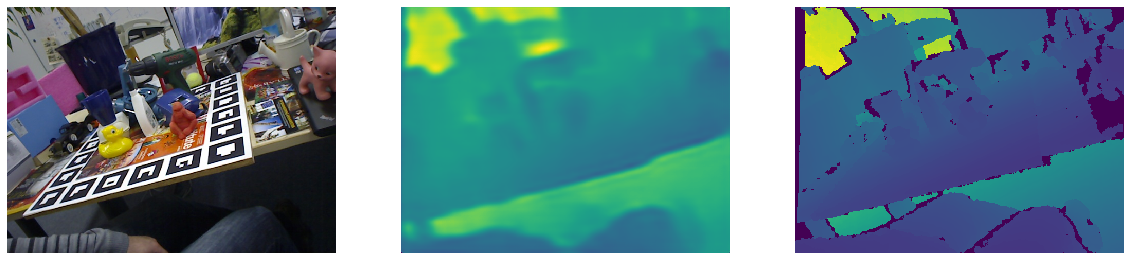

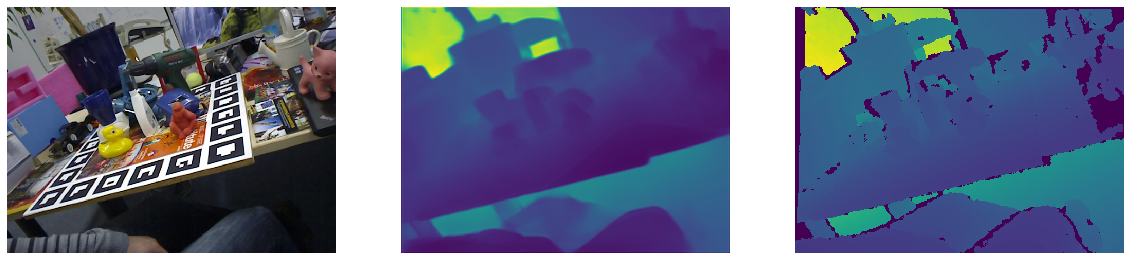

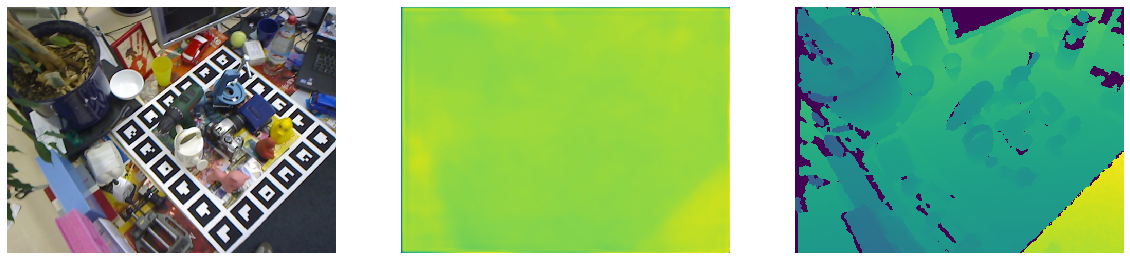

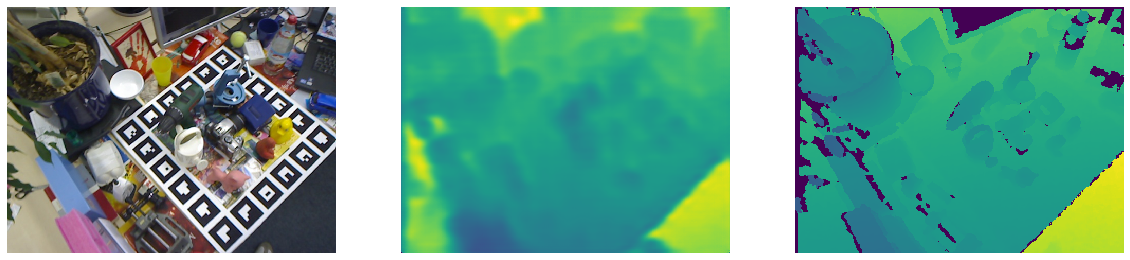

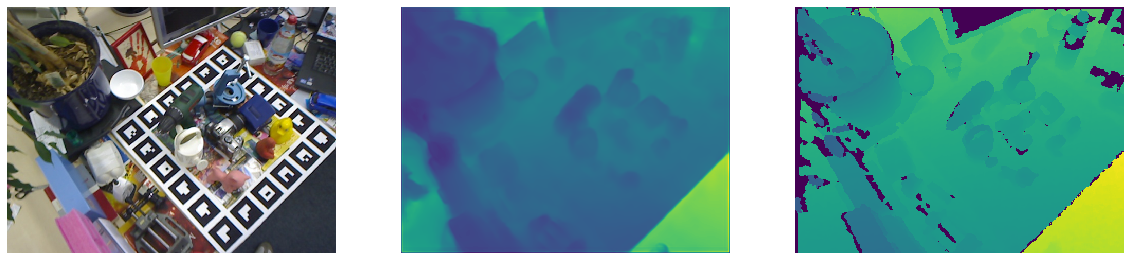

In [40]:
for i, data in enumerate(dataloader):
    img, depth = data
    img, depth = img[0].float().cuda().unsqueeze(0), depth[0].float().cuda().unsqueeze(0)
    plot_depth(1, img, depth)
    plot_depth(2, img, depth)
    plot_depth(3, img, depth)
    if (i+1) % 5 == 0:
        break
    
    

In [23]:
eval_models(3, dataloader)

{'MSE': 20441.836366523818, 'RMSE': 142.97495013646207, 'ABS_REL': 0.06398816366942184, 'LG10': 0.026938834137201887, 'MAE': 68.51553656198446, 'DELTA1': 0.9661553172231878, 'DELTA2': 0.9933798971685391, 'DELTA3': 0.9980529006245067}


In [24]:
eval_models(1, dataloader)

{'MSE': 179516.08534397755, 'RMSE': 423.6933860045228, 'ABS_REL': 0.20841094828346401, 'LG10': 0.10028357539796134, 'MAE': 248.57387781976496, 'DELTA1': 0.5822442116025944, 'DELTA2': 0.8831819702771683, 'DELTA3': 0.9660317443528221}


In [29]:
eval_models(2, dataloader)

{'MSE': 71051.4193511074, 'RMSE': 266.55472111952434, 'ABS_REL': 0.12199374994317305, 'LG10': 0.05350880371135416, 'MAE': 140.96887655165588, 'DELTA1': 0.8706423227069447, 'DELTA2': 0.9803724941698093, 'DELTA3': 0.9952507082698414}


# Store predicted depth results

In [5]:
mode = 'test'
root = "./datasets/linemod/Linemod_preprocessed"

In [7]:
objlist = [2, 4, 5, 10, 11]
item_count = 0

for item in objlist:
    files = []
    count = 0
    input_file = open('{0}/data/{1}/test.txt'.format(root, '%02d' % item))
    while 1:
        item_count += 1
        input_line = input_file.readline()
        if mode == 'test' and item_count % 10 != 0:
            continue
        if not input_line:
            break
        if input_line[-1:] == '\n':
            input_line = input_line[:-1]
        files.append(input_line) 

    folder_obj = '{0}/data/{1}/'.format(root, '%02d' % item)
    base_depth_predicted_path = folder_obj + 'depth_predicted'
    base_rgb_path = folder_obj + 'rgb'
#     os.mkdir(base_depth_predicted_path)

#     for file_name in files:
#         depth_path = base_depth_path + '/' + file_name + '.png'
#         rgb_img_path = base_rgb_path + '/' + file_name + '.png'
#         filled_depth_path = base_filled_path + '/' + file_name

#         depth = np.array(Image.open(depth_path))
#         rgb = np.array(Image.open(rgb_img_path).convert('RGB'))

#         output_depth = fill_depth_colorization(rgb, depth, 1)

#         np.save(filled_depth_path, output_depth)
#         print(depth_path, filled_depth_path)
#         count += 1
#         if count % 2 == 0:
#             print(count * 100 / len(files), "%")

#         if count % 50 == 0:

#             fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
#             max_d = np.max(depth)
#             min_d = np.min(depth)
#             depth_norm = (depth - min_d) * 255 / (max_d - min_d)

#             ax1.imshow(depth_norm)
#             ax1.axis("off")

#             max_d = np.max(output_depth)
#             min_d = np.min(output_depth)
#             depth_norm = (output_depth - min_d) * 255 / (max_d - min_d)
#             ax2.imshow(depth_norm)
#             ax2.axis("off")

#             plt.show()
